In [1]:
SQL_SOURCE = 'https://fb55.carto.com:443/api/v2/sql?q='

import pandas as pd
import numpy as np
import pylab as pl
import geopandas as gp
from sklearn.cluster import KMeans
import os 
#import urllib2
#import urllib
#import StringIO
import ast
import pandas as pd
import ast
import statsmodels.formula.api as smf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    data = urllib.urlencode({'format': format, 'q': query}).encode('utf-8')
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return response.read()

I start by importing the data from the nyc.gov porta for the crime rates and from the following url for the precincts shapefile which I place in my PUIDATA folder:
https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz/data

In [2]:
PUIdata = os.getenv("PUIDATA")

In [3]:
for file in os.listdir(PUIdata + "/precincts"):
    if file.endswith(".shp"):
        precincts = gp.GeoDataFrame.from_file(os.path.join(PUIdata + "/precincts", file))

In [4]:
url = 'https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/'\
    + 'seven-major-felony-offenses-by-precinct-2000-2016.xls'

In [5]:
df_felony = pd.read_excel(url, skiprows=2, nrows=615, skip_footer=20)

### 1.1

In [6]:
df_felony.PCT = df_felony.PCT.fillna(method = 'ffill') 

In [7]:
for i in range(0, len(df_felony)):
    df_felony.iloc[i, 1] = df_felony.iloc[i,1].replace(' ', '')

In [8]:
df_felony.CRIME = df_felony.CRIME.str.lower()

In [9]:
crimes = df_felony.CRIME.unique()

In [10]:
for i in range(0,len(df_felony)):
    df_felony.iloc[i, 1] = df_felony.iloc[i, 1].replace(crimes[0], 'murder')
    df_felony.iloc[i, 1] = df_felony.iloc[i, 1].replace(crimes[3], 'assault')
    df_felony.iloc[i, 1] = df_felony.iloc[i, 1].replace(crimes[5], 'larceny')
    df_felony.iloc[i, 1] = df_felony.iloc[i, 1].replace(crimes[6], 'larceny_of_vehicle')
    df_felony.iloc[i, 1] = df_felony.iloc[i, 1].replace(crimes[7], 'total')

### 1.2

Removing precint 121 which holds Nans and outliers and start preparing the data for plotting

In [11]:
df_felony = df_felony.dropna(axis=0)

In [12]:
crimes = df_felony.CRIME.unique()

In [13]:
df_felony.head()

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,1.0,murder,3.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0,0,1,0
1,1.0,rape,12.0,5.0,10.0,11.0,11.0,5.0,4.0,7.0,12.0,4.0,6.0,13.0,10.0,12,8,7,9
2,1.0,robbery,252.0,188.0,210.0,164.0,154.0,172.0,119.0,128.0,108.0,106.0,96.0,102.0,81.0,68,50,79,60
3,1.0,assault,139.0,164.0,147.0,134.0,129.0,121.0,94.0,90.0,83.0,83.0,68.0,94.0,110.0,87,76,86,78
4,1.0,burglary,475.0,437.0,297.0,403.0,246.0,293.0,255.0,231.0,189.0,207.0,170.0,155.0,188.0,171,145,138,117


In [14]:
years=df_felony.columns[2:]

In [15]:
df_felony.PCT=df_felony.PCT.astype(int)

In [16]:
precints=df_felony.PCT.unique()

In [17]:
precints=precints.astype(str)

In [18]:
df_crime = []
for i in range(0,len(crimes)):
    df_crime.append(df_felony[df_felony.CRIME == crimes[i]])
    df_crime[i] = df_crime[i].set_index(['PCT'])

### 1.3

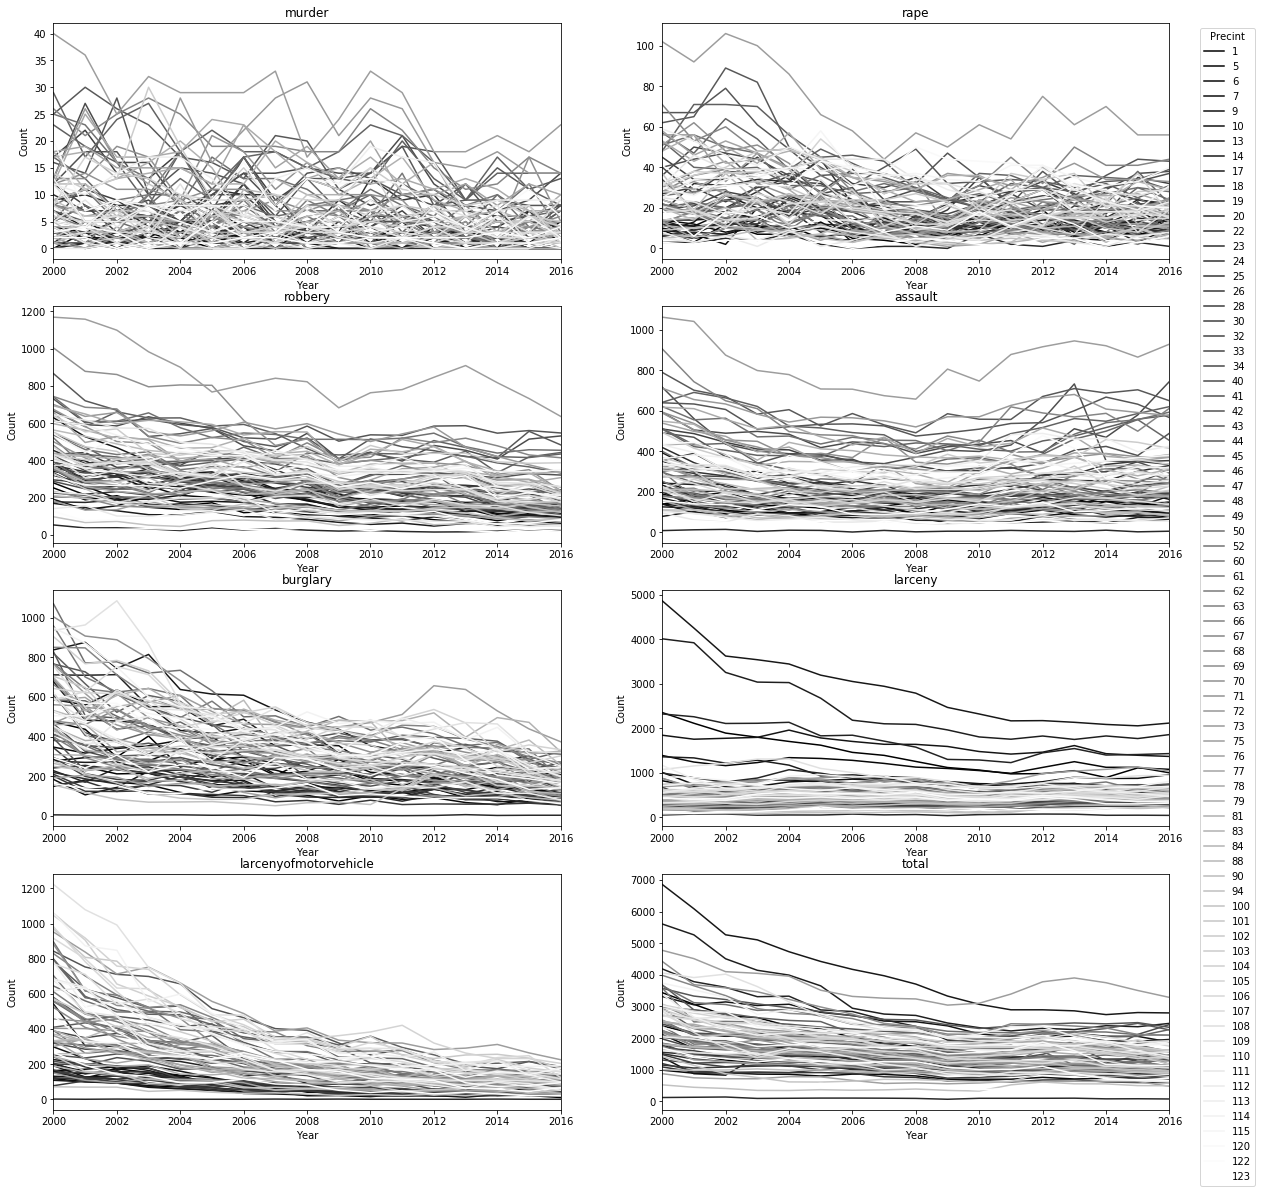

In [19]:
fig = pl.figure(figsize = (20 ,20))
ax0, ax1, ax2, ax3 = fig.add_subplot(421), fig.add_subplot(422), fig.add_subplot(423), fig.add_subplot(424)
ax4, ax5, ax6, ax7 = fig.add_subplot(425), fig.add_subplot(426), fig.add_subplot(427), fig.add_subplot(428)
leg=[False,True,False,False,False,False,False,False]
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]
for i in range(0,len(crimes)):
    df_crime[i].T.iloc[1:].plot(ax = axes[i], legend=leg[i], alpha=1, colormap='gist_gray')
    if leg[i]:
        axes[i].legend(precints,title='Precint', bbox_to_anchor=(1.05, 1))
    #axes[i].set_xticklabels(range(2000,2016), rotation=45)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Year')
    axes[i].set_title(crimes[i]);

#####                    Figure 1. Crime rate evolution since 2000 by crime type and total crimes by precint for 76 precints of NYC
We observe an overall decrease trend for most crime rates with the exception of: assault, and in some precints, murder & rape.

Color. The grayscale used to plot lines is less disturbing than random colors associated with each precint. Given that a certain range of precints corresponds to a certain borrough, here we get a vague sense of which set of precints hold the highest/lowest crime rates; e.g. We can infer, from the quasi-black color of the lines with the most counts, there are high larceny rates in the first range of precints (0-34), which correspond to Manhattan. We can also see how this crime impacts the total crime rate, which also places a precint in Manhattan as the one with the most crimes until 2010 followed by one that is probably in Brooklyn (60-90).

Precint 75 might seem like an outlier for the first graphs but the values are consistent with what is published by the police department:
https://www1.nyc.gov/assets/nypd/downloads/pdf/crime_statistics/cs-en-us-075pct.pdf

### 1.4 

I will create two data cubes for that hold the means and standard deviations over time for each precint and each crime.

In [20]:
c = int()
m = np.zeros([len(precints), 16, len(crimes)])
for i in range(0, 76): 
    for k in range(0, 8):
        for j in range(4, 20):
            m[i][j-4][k] = df_felony.iloc[c,2:j].mean()
        c += 1

In [21]:
c = 0
sigma = np.zeros([len(precints), 16, len(crimes)])
for i in range(0, 76): 
    for k in range(0, 8):
        for j in range(4, 20):
            sigma[i][j-4][k] = df_felony.iloc[c, 2:j].std()
        c += 1

I'll plot some of the crime means and standard deviations for precint 1 to corroborate that the data cubes are correct

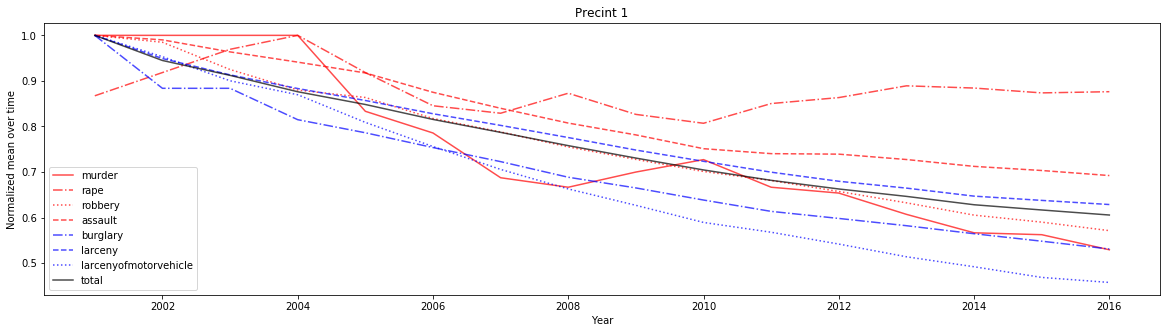

In [22]:
figsize(20, 5)
mplot = np.empty(16)
stdplot = np.empty(16)
crimeplot = np.empty(16)
color = ['r', 'r', 'r', 'r', 'b', 'b', 'b', 'k']
line = ['-', '-.', ':', '--', '-.', '--', ':', '-']
for k in range(0, 8):
    for j in range(0, 16):
        mplot[j] = m[0][j][k]
        #stdplot[j] = sigma[0][j][k]
        #crimeplot[j] = df_felony.iloc[k, 2+j]
    #pl.plot(range(2001,2017),crimeplot/np.max(crimeplot),'k',alpha=0.4)
    pl.plot(range(2001, 2017), mplot/np.max(mplot), color = color[k], linestyle = line[k], alpha = 0.7)
    
pl.legend(crimes);
pl.xlabel('Year')
pl.ylabel('Normalized mean over time')
pl.title('Precint 1');
#pl.ylim(0,500);

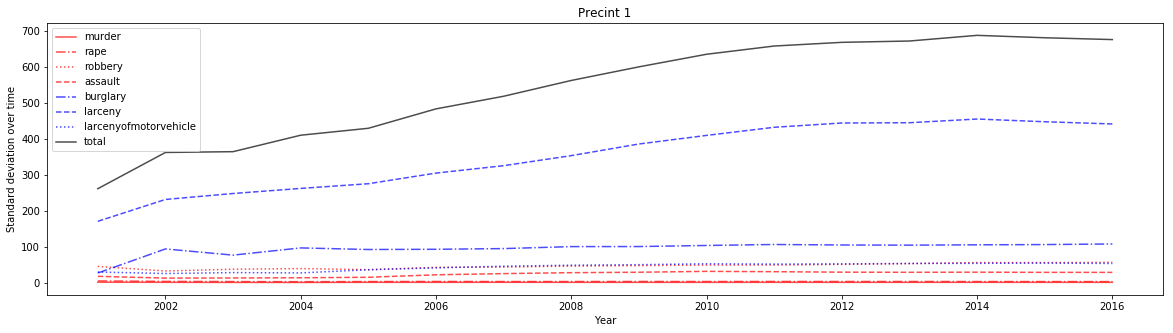

In [23]:
for k in range(0, 8):
    for j in range(0, 16):
        #mplot[j] = m[0][j][k]
        stdplot[j] = sigma[0][j][k]
        #crimeplot[j] = df_felony.iloc[k, 2+j]
    #pl.plot(range(2001,2017),crimeplot/np.max(crimeplot),'k',alpha=0.4)
    #pl.plot(range(2001,2017),mplot/np.max(mplot),color=color[k],linestyle=line[k],alpha=0.7)
    pl.plot(range(2001, 2017), stdplot, color = color[k], linestyle = line[k], alpha = 0.7)
pl.legend(crimes);
pl.xlabel('Year')
pl.ylabel('Standard deviation over time')
pl.title('Precint 1');

### 1.5

I will start with normalizing the data df_crime[7], which holds the information for total number of crimes by year, in order to cluster it. Then I will group the precints into 2-10 clusters to see which number better fits the data by looking at the minimum number of precints in each cluster. The one that has a minimum of more that 5% is the one I will choose. It is similar to what I did on the secon part of the clustering analysis although my threshold changed to 10% instead of 5 to have a total of 6 cluster.

In [24]:
df_total = df_crime[7].iloc[:, 1:]

In [25]:
for i in range(0, len(df_total)):
    sigma = df_total.iloc[i, :].std()
    mu = df_total.iloc[i, :].mean()
    for j in range(0, 17):
        df_total.iloc[i, j] = (df_total.iloc[i, j]-mu) / sigma

In [26]:

for i in range(2,10):
    n=[]
    sigma=0
    KM = KMeans(n_clusters = i, random_state = 123).fit(df_total.iloc[:,0:17])
    df_total['KM'+str(i)]=KM.labels_
    for j in range(0,i):
        n.append(len(df_total[df_total['KM'+str(i)]==j]))
    sigma=np.std(n)
    print(('For {} the percentage of information contained in the cluster'+
           ' with minimum of precints is {}%').format('KM'+str(i),int((np.min(n)/76)*100)))

For KM2 the percentage of information contained in the cluster with minimum of precints is 15%
For KM3 the percentage of information contained in the cluster with minimum of precints is 6%
For KM4 the percentage of information contained in the cluster with minimum of precints is 3%
For KM5 the percentage of information contained in the cluster with minimum of precints is 2%
For KM6 the percentage of information contained in the cluster with minimum of precints is 1%
For KM7 the percentage of information contained in the cluster with minimum of precints is 1%
For KM8 the percentage of information contained in the cluster with minimum of precints is 1%
For KM9 the percentage of information contained in the cluster with minimum of precints is 1%


After seeing this I will choose a maximum number of 3 clusters and see which trends they display

In [27]:
KM = KMeans(n_clusters = 3, random_state = 123).fit(df_total.iloc[:,0:17])

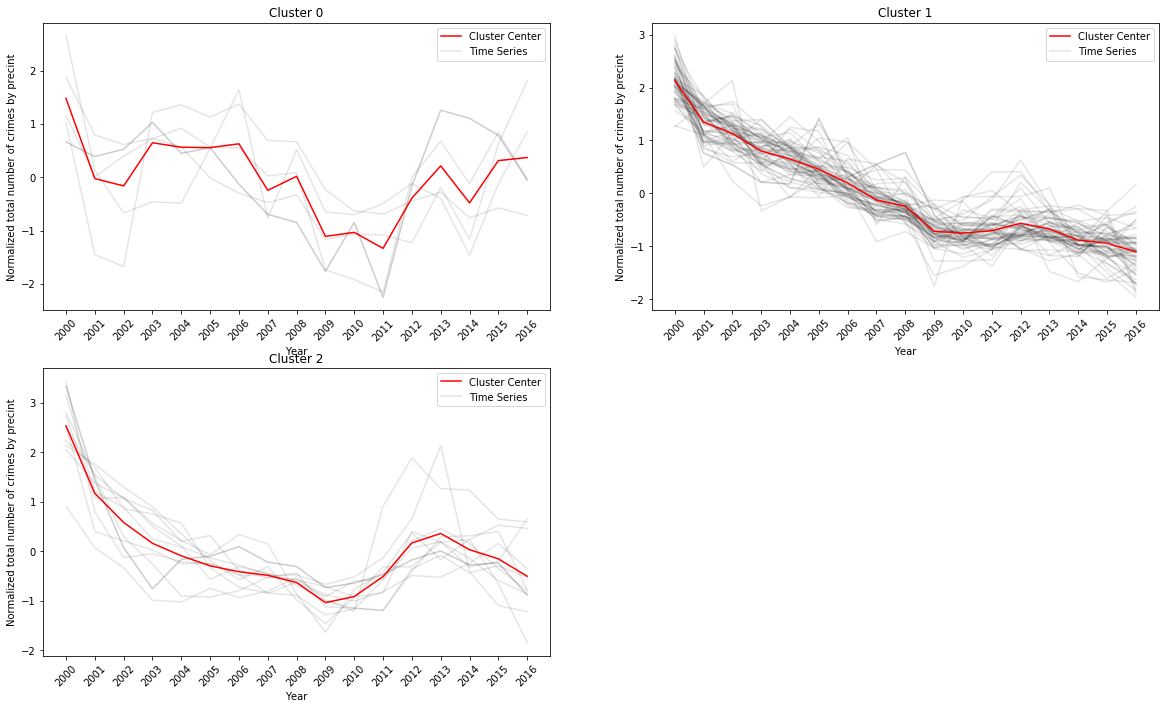

In [28]:
fig = pl.figure(figsize = (20 ,18))
ax0,ax1,ax2 = fig.add_subplot(321), fig.add_subplot(322), fig.add_subplot(323)
cluster = [0, 1, 2, 3, 4, 5]
index = [ax0, ax1, ax2]
for k in range(0,3):
    for i in range(0,len(df_total[(df_total.KM3==k)])):
        index[k].plot(range(2000, 2017),df_total[(df_total.KM3==k)].iloc[i,0:17], color='k', alpha=0.1)
    clusterc,=index[k].plot(range(2000, 2017), KM.cluster_centers_[cluster[k]], color='r',label='Cluster Center')
    timeseries,=index[k].plot(range(2000, 2017),df_total[(df_total.KM3==k)].iloc[i,0:17], color='k', alpha=0.1,label='Time Series')
    index[k].set_xticks(range(2000, 2017));
    index[k].set_xticklabels(range(2000, 2017), rotation=45)
    index[k].set_ylabel('Normalized total number of crimes by precint')
    index[k].set_xlabel('Year')
    index[k].legend(handles=[clusterc,timeseries],loc=1)
    index[k].set_title('Cluster '+str(k))
    index[k];

#### Fig. 4 Three clusters are plotted for total number of crimes by precint. 
For cluste 1 and 2 we observe a decreasing trend over the years with a slight valley from between 2009 and 2012. The peak that comes after that valley for cluster 2 is more pronounced than that of cluster 1. Cluster 0 presents the most irregular trend although it does show a valley for 2009 thorough 2012 as well followed by a peak.

#### 2.1

In [29]:
df_total=gp.GeoDataFrame(df_total)

In [30]:
precincts=precincts.rename(columns={'precinct':'PCT'})

In [31]:
precincts.PCT=precincts.PCT.astype(int)

In [32]:
df_total=df_total.reset_index()

#### 2.2

In [33]:
df_total=df_total.merge(precincts,on='PCT')

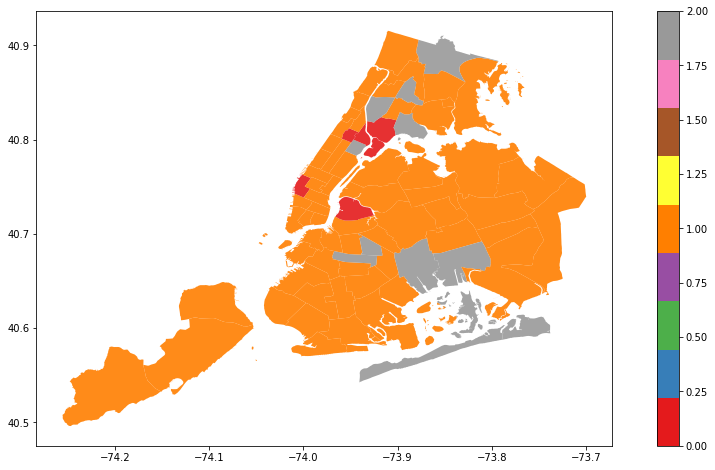

In [34]:
df_total.plot(column = 'KM3', cmap="Set1", figsize = (16,8), legend = True, alpha = 0.9);

#### Figure 4

From the time series plots we can interpret that cluster 1 has historically had the most crimes, followed by cluster 2 and finally cluster 0. With the clusters now spatially plotted we can assess total criminal activity in certain areas but what would be of actual interest to plot would be the normalized criminal activty by population in order to draw better conclusions.

#### 2.3

In [35]:
test = '''
SELECT precinct,green,unemployment,medianincome
FROM nycsocioeconomicsbyprecinct
'''

df_socio=pd.read_csv(StringIO.StringIO(queryCartoDB(test)), sep=',')

In [36]:
df_socio = pd.read_csv('socio.csv')

In [37]:
df_socio = df_socio.drop('Unnamed: 0', axis = 1)

#### 2.4 & 2.5

In [38]:
crime_mean = np.zeros([76, len(crimes)])
for k in range(0, len(crimes)):
    for i in range(0, 76):
        crime_mean[i][k] = np.mean(df_crime[k].iloc[i, 1:])

In [39]:
df_crime_mean = pd.DataFrame(crime_mean, columns = crimes)

In [40]:
df_crime_mean['PCT'] = precints

In [41]:
df_socio = df_socio.rename(columns = {'precinct':'PCT'})

In [42]:
df_socio.PCT = df_socio.PCT.astype(str)

In [43]:
df_crime_mean = df_crime_mean.merge(df_socio,on = 'PCT')
#df_crime_mean=df_crime_mean.set_index('PCT')

In [44]:
precincts.PCT = precincts.PCT.astype(str)

In [45]:
df_crime_mean = df_crime_mean.merge(pd.DataFrame(precincts), on = 'PCT')

In [46]:
df_crime_mean = gp.GeoDataFrame(df_crime_mean)

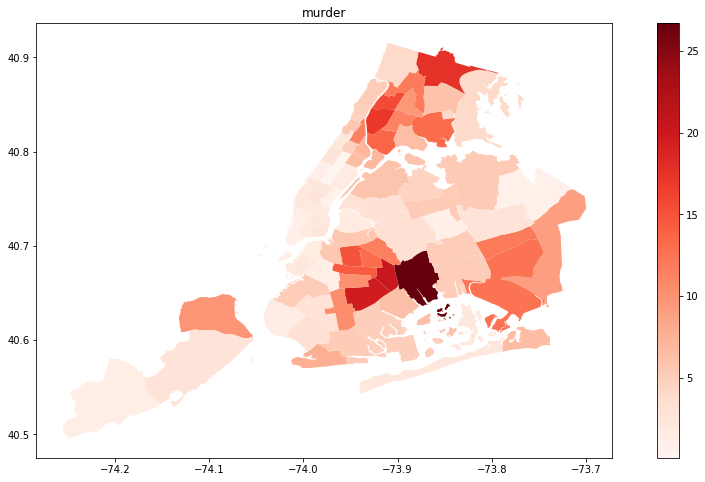

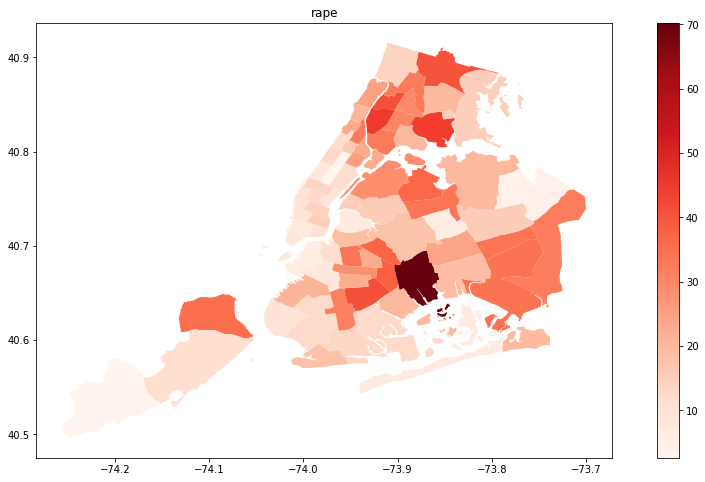

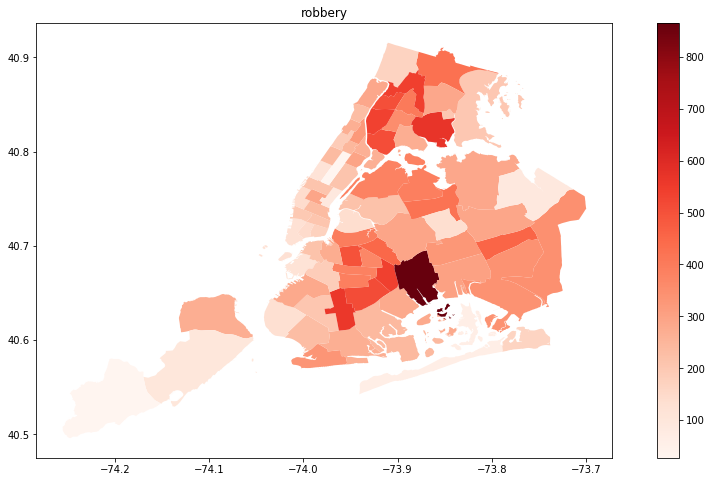

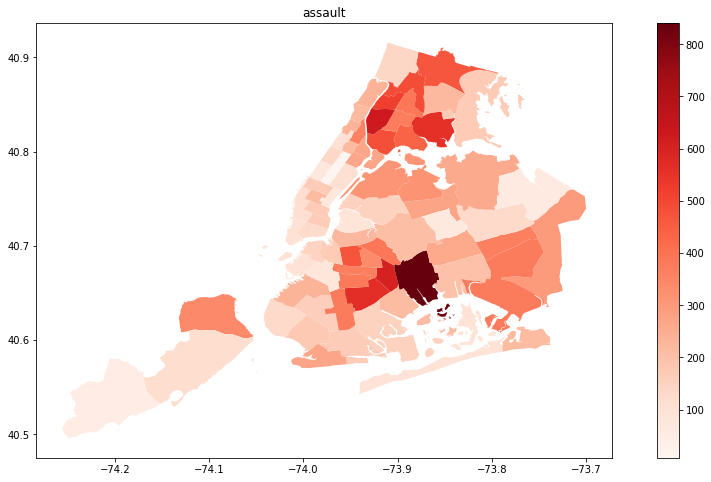

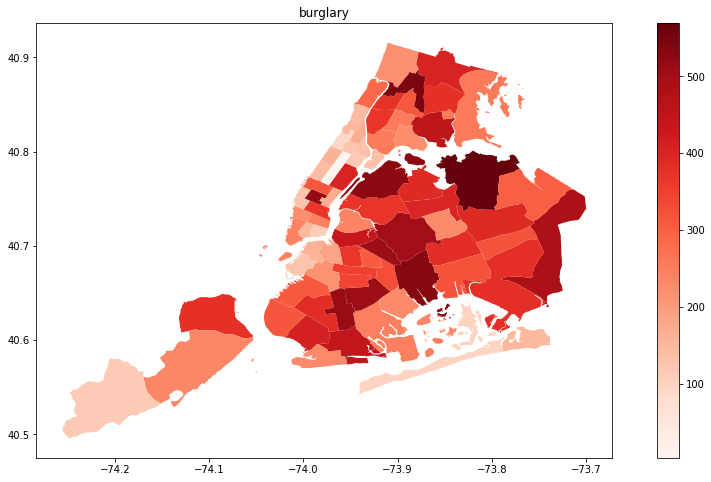

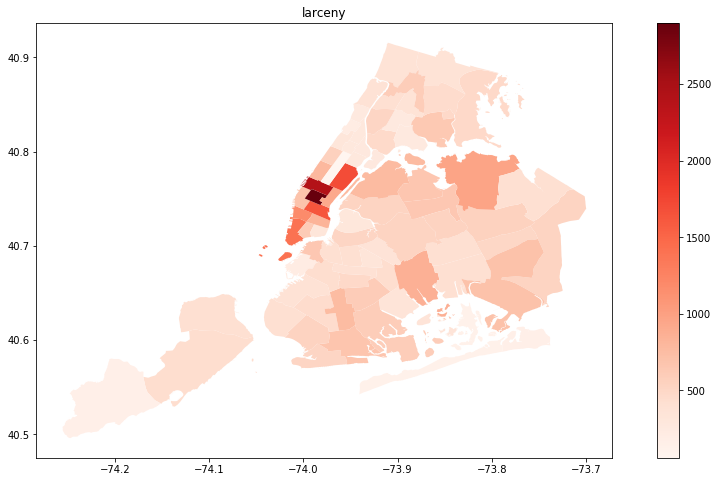

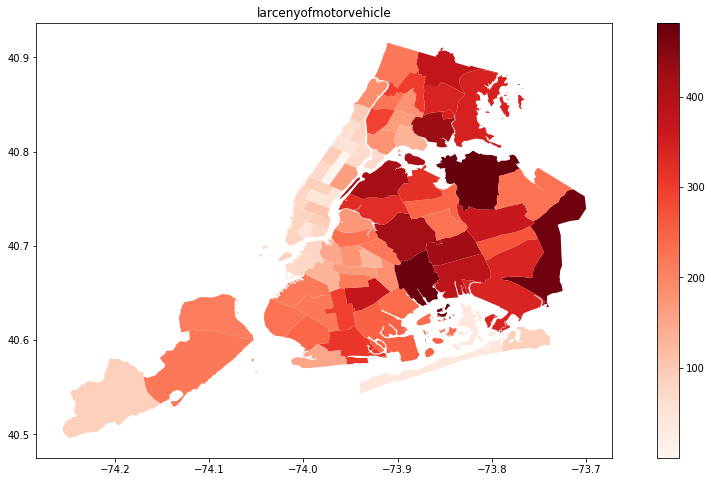

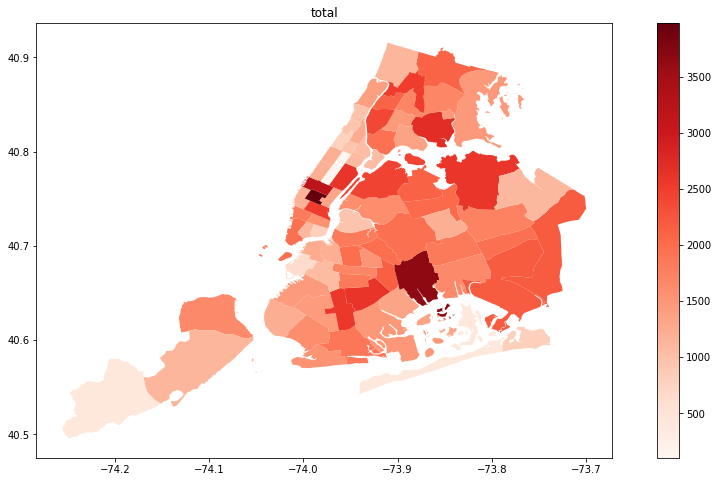

In [47]:
for i in range(0, len(crimes)):
    df_crime_mean.plot(column = crimes[i], cmap="Reds", figsize = (16,8), legend = True)
    pl.title(crimes[i]);

#### Figure 5
Plot of the number of crimes for each precint by type of felony and total crime. We see from the choropleths that East New York has one of the highest number of crimes except for larceny. Areas around flatbush and the south of the Bronx also remain like constat red areas on the map except for larceny and larceny of motor vehicle which we mainly see in Manhattan in the first case and in Queens in the latter. Crime in Staten Island is relatively low except for the north eastern part of it. Although these plots could help realocet police reinforcement or to create certain scpecific programs that target social and economic fabric improvement I think a more intesting plot of chorpleths would be to plot the normalized crime rates by population, in order to identify the most violent areas in the city.

#### 2.6

In [48]:
socio_norm = np.zeros([76, 3])
for j in range(9, 12):
    mu = df_crime_mean.iloc[:,j].mean()
    std = df_crime_mean.iloc[:,j].std()
    for i in range(0, 76):
        socio_norm[i,j-9] = (df_crime_mean.iloc[i,j]-mu)/std

In [49]:
df_crime_mean = pd.concat([df_crime_mean,pd.DataFrame(socio_norm)], axis = 1)

In [50]:
df_crime_mean = df_crime_mean.rename(columns = {0:'green_norm',1:'unemployed_norm',2:'median_income_norm'})

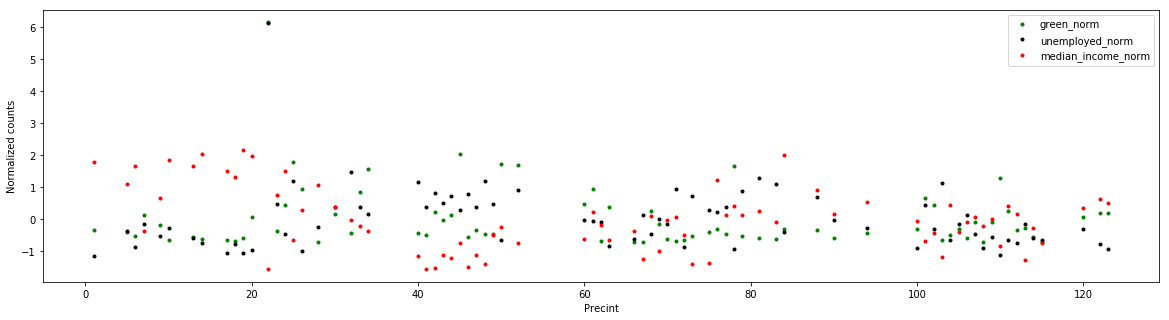

In [51]:
pl.plot(precints, df_crime_mean.iloc[:,15], '.', color = 'g')
pl.plot(precints, df_crime_mean.iloc[:,16], '.', color = 'k')
pl.plot(precints, df_crime_mean.iloc[:,17], '.', color = 'r')
pl.legend()
pl.xlabel('Precint')
pl.ylabel('Normalized counts')

#### Figure 6
Scatter plot of socio economic features (normalized park ratio, normalized unemployed ratio and normalized median income.

Here I follow the same methology for choosing clusters in the past clustering analysis and go with a total of 6 clusters.

In [52]:
for i in range(2, 10):
    n = []
    sigma = 0
    KM = KMeans(n_clusters = i, random_state = 123).fit(df_crime_mean.iloc[:,9:12])
    df_crime_mean['KM' + str(i)]=KM.labels_
    for j in range(0, i):
        n.append(len(crime_mean[df_crime_mean['KM'+str(i)] == j]))
    sigma=np.std(n)
    print(('For {} the percentage of information contained in the cluster'+
           ' with minimum of precincts is {}%').format('KM'+str(i), int((np.min(n)/76)*100)))

For KM2 the percentage of information contained in the cluster with minimum of precincts is 35%
For KM3 the percentage of information contained in the cluster with minimum of precincts is 19%
For KM4 the percentage of information contained in the cluster with minimum of precincts is 18%
For KM5 the percentage of information contained in the cluster with minimum of precincts is 10%
For KM6 the percentage of information contained in the cluster with minimum of precincts is 9%
For KM7 the percentage of information contained in the cluster with minimum of precincts is 9%
For KM8 the percentage of information contained in the cluster with minimum of precincts is 7%
For KM9 the percentage of information contained in the cluster with minimum of precincts is 6%


In [53]:
df_crime_mean['income_norm'] = df_crime_mean['medianincome'] / np.max(df_crime_mean['medianincome'])

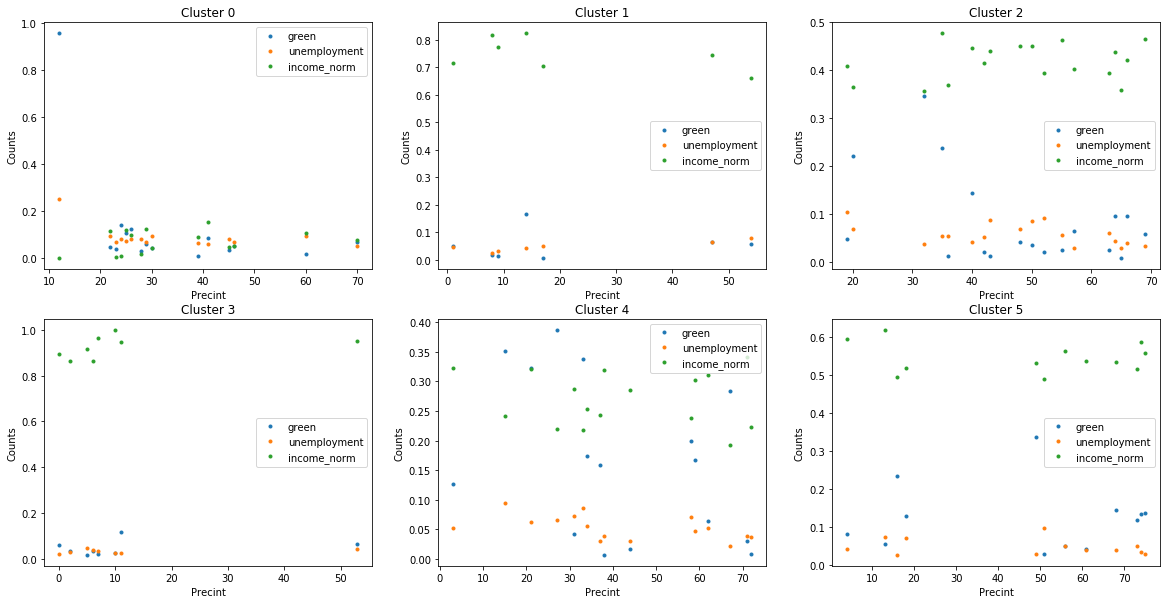

In [54]:
fig = pl.figure(figsize = (20 ,10))
ax0, ax1, ax2 = fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233)
ax3, ax4, ax5 = fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236)
index = [ax0,ax1,ax2,ax3,ax4,ax5]
#socio_var=['green','unemployment','medianincome']
#socio_var1=['green_norm','unemployed_norm','median_income_norm']
socio_var2 = ['green', 'unemployment', 'income_norm']
label = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']
tick = []
for j in range(0  ,6):
    for i in range(0,3):
        index[j].plot(df_crime_mean[df_crime_mean.KM6 == j][socio_var2[i]], '.')
        index[j].set_xlabel('Precint')
        index[j].set_ylabel('Counts')
        index[j].set_title('Cluster ' + str(j))
        index[j].legend();

#### Figure 7
Scatter plots for each group of clusters based on socio economic factors; each plot shows the green and employment ratio with a normalized income.

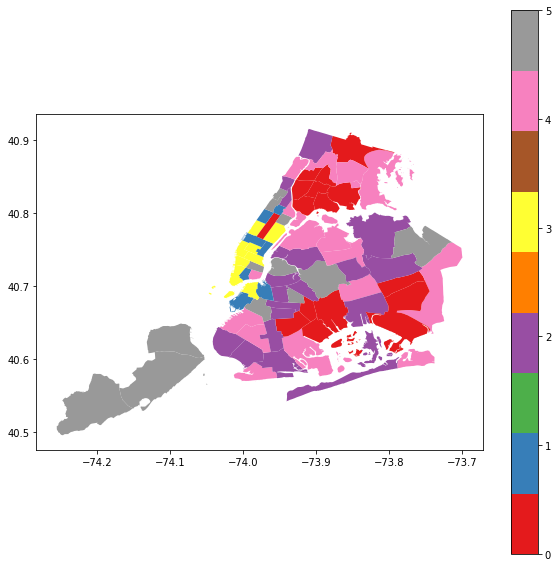

In [55]:
df_crime_mean.plot(column = 'KM6', cmap = "Set1", figsize = (10, 10), legend = True);

#### Figure 7.
Plot of the 6 different clusters based on socio economic factors like percentage of green, unemployment rate and median income.

In [56]:
for i in range(2, 10):
    n = []
    sigma = 0
    KM = KMeans(n_clusters = i, random_state = 123).fit(df_crime_mean.iloc[:, 0:7])
    df_crime_mean['FM' + str(i)] = KM.labels_
    for j in range(0 ,i):
        n.append(len(crime_mean[df_crime_mean['KM' + str(i)] == j]))
    sigma = np.std(n)
    print(('For {} the percentage of information contained in the cluster'+
           ' with minimum of precincts is {}%').format('KM' + str(i), int((np.min(n) / 76) * 100)))

For KM2 the percentage of information contained in the cluster with minimum of precincts is 35%
For KM3 the percentage of information contained in the cluster with minimum of precincts is 19%
For KM4 the percentage of information contained in the cluster with minimum of precincts is 18%
For KM5 the percentage of information contained in the cluster with minimum of precincts is 10%
For KM6 the percentage of information contained in the cluster with minimum of precincts is 9%
For KM7 the percentage of information contained in the cluster with minimum of precincts is 9%
For KM8 the percentage of information contained in the cluster with minimum of precincts is 7%
For KM9 the percentage of information contained in the cluster with minimum of precincts is 6%


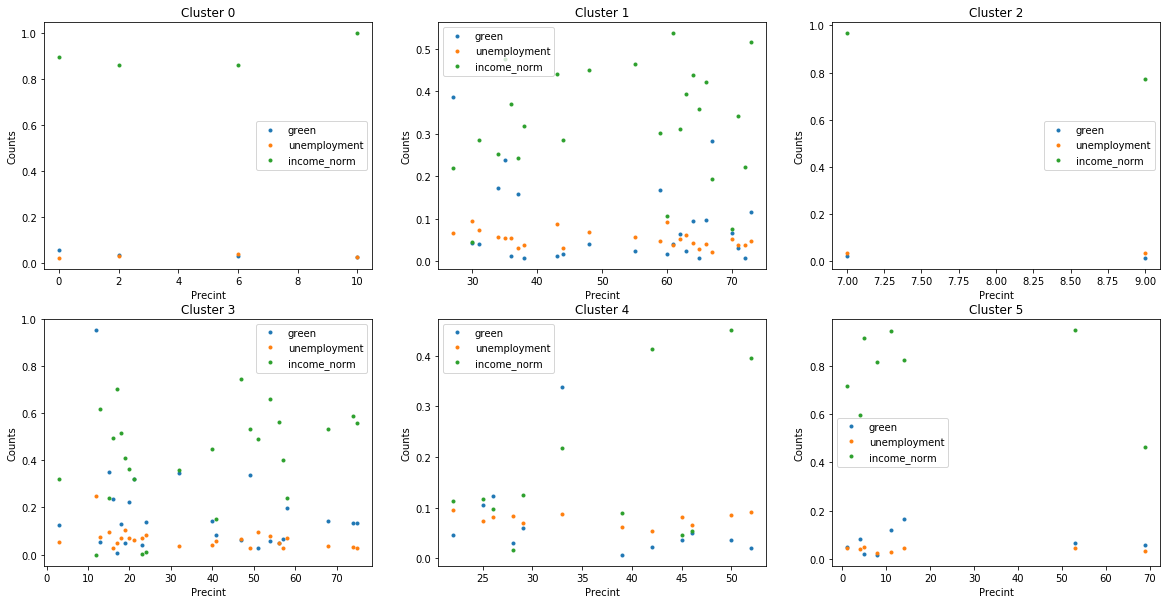

In [57]:
fig = pl.figure(figsize = (20 ,10))
ax0, ax1, ax2 = fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233)
ax3, ax4, ax5 = fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236),
index = [ax0, ax1, ax2, ax3, ax4, ax5]
#socio_var=['green','unemployment','medianincome']
#socio_var1=['green_norm','unemployed_norm','median_income_norm']
socio_var2 = ['green', 'unemployment', 'income_norm']
label = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']
tick = []
for j in range(0, 6):
    for i in range(0, 3):
        index[j].plot(df_crime_mean[df_crime_mean.FM6 == j][socio_var2[i]], '.')
        index[j].set_xlabel('Precint')
        index[j].set_ylabel('Counts')
        index[j].set_title('Cluster ' + str(j))
        index[j].legend();

#### Figure 8
Scatter plots with clusters made from crime rates by felony for each precinct; they show the socio economic factors used in the past plot in orther to compare them.

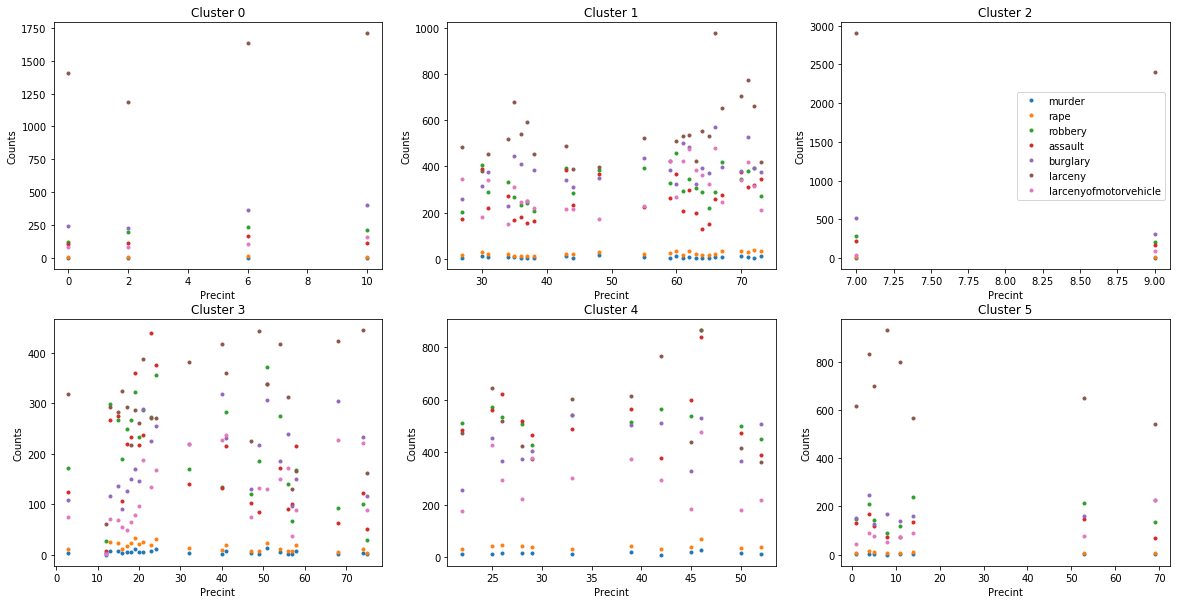

In [58]:
fig = pl.figure(figsize = (20 ,10))
ax0, ax1, ax2 = fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233)
ax3, ax4, ax5 = fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236)
index=[ax0, ax1, ax2, ax3, ax4, ax5]
#socio_var1=['green_norm','unemployed_norm','median_income_norm']
#socio_var2=['green','unemployment','income_norm']
felony = crimes[:-1]
label = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']
tick=[]
for j in range(0, 6):
    for i in range(0, 7):
        index[j].plot(df_crime_mean[df_crime_mean.FM6 == j][felony[i]], '.')
        index[j].set_xlabel('Precint')
        index[j].set_ylabel('Counts')
        index[j].set_title('Cluster ' + str(j))
ax2.legend();

#### Figure 9
Scatter plots of each cluster made with crime rates by felony for each precinct.

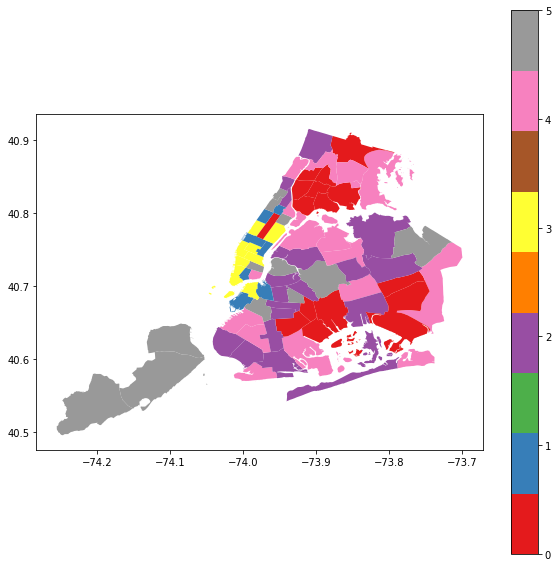

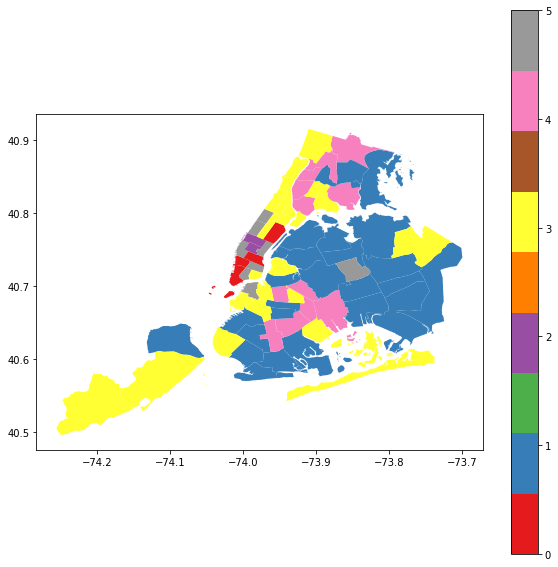

In [59]:
df_crime_mean.plot(column = 'KM6', cmap="Set1", figsize = (10,10), legend = True);
df_crime_mean.plot(column = 'FM6', cmap="Set1", figsize = (10,10), legend = True);

#### Figure 10
These two maps show the plot of the clusters, the first one was created with socioeconomic features and the second one was created with the crime type features. 

We can see similar clustering in Brooklyn: Mostly separeted into thre main groups: areas around East New York and Flatbush, Rockaway beach and bayridge and all thats left. 

In the first graph Queens is divided mainly into cluster 2 and 4 with the exception of the north eastern part which belongs to cluster five. In the second one it stays pretty homogenues except for the north eastern part as well, areas around Bay Side etc. 

Staten Island is pretty homogenous as well, but we see the north eastern part that seprates itself from the others in the last cluster, we saw this when plotting number of crimes, I assume it is the most populated area in Staten Island. Manhattan has a complex socio demographic geography, we can see three main groups that divide it into lower Manhatta, midtown and upper Manhattan. 

The Bronx has a complex socio demographic geography as well, it can be divided into thre groups: areas that ara close to Washington heights on the upper west side, areas close to Harlem on the southern west part and then there is Parkchester and West Bronx.

#### 2.7

In [60]:
socio_var = ['green', 'unemployment', 'median income']

The function I created looks for the highest coefficient amongst al features but only chooses one that has a p value lower than 0.05 as the best feature and returns the linear model.

In [61]:
def predictCrime(fellony):
    flag = 0
    pvalues = []
    coef = []
    model_arg = fellony+' ~ green + unemployment + medianincome'
    model = smf.ols(model_arg, df_crime_mean).fit()
    c=1
    for i in range(1, 4):
        pvalues.append(model.pvalues[i])
    for i in range(1, 4):
        coef.append(np.abs(model.params[i]))
        coef_sort = np.sort(coef)
    while flag == 0:
        max = coef_sort[-c]
        max_index = coef.index(max)
        if pvalues[max_index] <= 0.05:
            feature = socio_var[max_index]
            params = model.params[max_index]
            flag = 1
        c += 1
    print(('For {} prediction; the most important feature for prediction is: {}\n'+
            'with a p-value of {}\na regressor coefficient of: {}\n'+
            'and an R-squared of {}').format(fellony, feature, pvalues[max_index], params,model.rsquared))
    return(model);

In [62]:
predictCrime('murder')

For murder prediction; the most important feature for prediction is: unemployment
with a p-value of 0.00044194812461540003
a regressor coefficient of: -20.61264403505955
and an R-squared of 0.5731216024389801


In [63]:
predictCrime('rape')

For rape prediction; the most important feature for prediction is: green
with a p-value of 1.695681768406643e-05
a regressor coefficient of: 33.72289119036472
and an R-squared of 0.5156713026090591


In [64]:
predictCrime('burglary')

For burglary prediction; the most important feature for prediction is: green
with a p-value of 0.005814567494522037
a regressor coefficient of: 455.8933081389421
and an R-squared of 0.223923728887232


In [65]:
predictCrime('total')

For total prediction; the most important feature for prediction is: green
with a p-value of 0.002150844482357476
a regressor coefficient of: 2131.8166218683796
and an R-squared of 0.1647142755393215


For an alpha of 0.05

With a multivariate linear regression model the park ratio per precinct turns out to be the best predictor for rape, burglary and total amount of crimes; meaning it has the highest coefficient regressor and lower p value than alpha's 5% (the null is rejected). For models that take predict crime with green as main prediction feature, we get a decent R-squared values over 0.5 and less powerful one for the total number of crimes (0.16). For the one that predicts murder with unemplyment as variable we get a similar R-squared than those that predict crime with park ratio as a variable.